# Import libraries


In [33]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torchvision
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from collections import OrderedDict
import json

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Load the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Data/flower'

/content/drive/MyDrive/Data/flower


In [4]:
%pwd

'/content/drive/MyDrive/Data/flower'

In [ ]:
import zipfile
from zipfile import ZipFile

with ZipFile('flower.zip', 'r') as zipObj:
    zipObj.extractall()

In [5]:
data_transforms = {
    'training': transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])]),
    'validation': transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])]),
    'testing': transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])
}

In [6]:
data_dir = '/content/drive/MyDrive/Data/flower'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
image_datasets = {
    'training' : datasets.ImageFolder(train_dir, transform=data_transforms['training']),
    'testing' : datasets.ImageFolder(test_dir, transform=data_transforms['testing']),
    'validation' : datasets.ImageFolder(valid_dir, transform=data_transforms['validation'])
}

In [7]:
dataloaders = {
    'training' : torch.utils.data.DataLoader(image_datasets['training'], batch_size=64, shuffle=True),
    'testing' : torch.utils.data.DataLoader(image_datasets['testing'], batch_size=64, shuffle=False),
    'validation' : torch.utils.data.DataLoader(image_datasets['validation'], batch_size=64, shuffle=True)
}

In [8]:
class_to_idx = image_datasets['training'].class_to_idx
class_to_idx

{'1': 0,
 '10': 1,
 '100': 2,
 '101': 3,
 '102': 4,
 '11': 5,
 '12': 6,
 '13': 7,
 '14': 8,
 '15': 9,
 '16': 10,
 '17': 11,
 '18': 12,
 '19': 13,
 '2': 14,
 '20': 15,
 '21': 16,
 '22': 17,
 '23': 18,
 '24': 19,
 '25': 20,
 '26': 21,
 '27': 22,
 '28': 23,
 '29': 24,
 '3': 25,
 '30': 26,
 '31': 27,
 '32': 28,
 '33': 29,
 '34': 30,
 '35': 31,
 '36': 32,
 '37': 33,
 '38': 34,
 '39': 35,
 '4': 36,
 '40': 37,
 '41': 38,
 '42': 39,
 '43': 40,
 '44': 41,
 '45': 42,
 '46': 43,
 '47': 44,
 '48': 45,
 '49': 46,
 '5': 47,
 '50': 48,
 '51': 49,
 '52': 50,
 '53': 51,
 '54': 52,
 '55': 53,
 '56': 54,
 '57': 55,
 '58': 56,
 '59': 57,
 '6': 58,
 '60': 59,
 '61': 60,
 '62': 61,
 '63': 62,
 '64': 63,
 '65': 64,
 '66': 65,
 '67': 66,
 '68': 67,
 '69': 68,
 '7': 69,
 '70': 70,
 '71': 71,
 '72': 72,
 '73': 73,
 '74': 74,
 '75': 75,
 '76': 76,
 '77': 77,
 '78': 78,
 '79': 79,
 '8': 80,
 '80': 81,
 '81': 82,
 '82': 83,
 '83': 84,
 '84': 85,
 '85': 86,
 '86': 87,
 '87': 88,
 '88': 89,
 '89': 90,
 '9': 91,
 '90

224


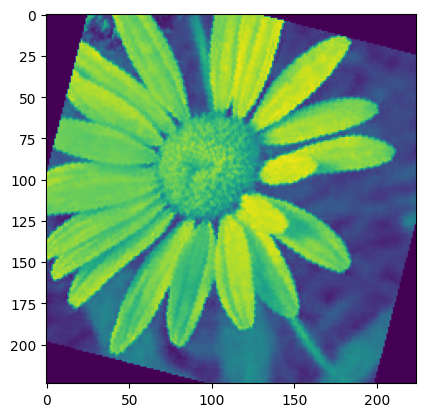

In [9]:
images, labels = next(iter(dataloaders["training"]))
print(len(images[0,0]))
plt.imshow(images[0,0])

# Label mapping

In [34]:
with open('/content/cat_to_name.json','r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

In [10]:
def get_model():
    model = models.densenet121(pretrained=True)
    return model

def build_model(hidden_layers, class_to_idx):
    model = get_model()
    for param in model.parameters():
        param.requires_grad = False

    classifier_input_size = model.classifier.in_features
    print("Input size: ", classifier_input_size)
    output_size = 102

    from collections import OrderedDict
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(classifier_input_size, hidden_layers)),
        ('relu', nn.ReLU()),
        ('fc2', nn.Linear(hidden_layers, output_size)),
        ('output', nn.LogSoftmax(dim=1))
    ]))

    model.classifier = classifier
    model.class_to_idx = class_to_idx
    return model

In [11]:
hidden_layers = 512
model = build_model(hidden_layers, class_to_idx)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 136MB/s]


Input size:  1024


In [17]:
def train(model, epochs, learning_rate, criterion, optimizer, training_loader, validation_loader):

    model.train()
    print_every = 40
    steps = 0
    use_gpu = False

    if torch.cuda.is_available():
        use_gpu = True
        model.cuda()
    else:
        model.cpu()

    for epoch in range(epochs):
        running_loss = 0
        for inputs, labels in iter(training_loader):
            steps += 1

            if use_gpu:
                inputs = Variable(inputs.float().cuda())
                labels = Variable(labels.long().cuda())
            else:
                inputs = Variable(inputs)
                labels = Variable(labels)

            optimizer.zero_grad()
            output = model.forward(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.data.item()

            if steps % print_every == 0:
                validation_loss, accuracy = validate(model, criterion, validation_loader)

                print("Epoch: {}/{} ".format(epoch+1, epochs),
                        "Training Loss: {:.3f} ".format(running_loss/print_every),
                        "Validation Loss: {:.3f} ".format(validation_loss),
                        "Validation Accuracy: {:.3f}".format(accuracy))

In [18]:
def validate(model, criterion, data_loader):
    model.eval()
    accuracy = 0
    test_loss = 0

    for inputs, labels in iter(data_loader):
        if torch.cuda.is_available():
            inputs = Variable(inputs.float().cuda(), volatile=True)
            labels = Variable(labels.long().cuda(), volatile=True)
        else:
            inputs = Variable(inputs, volatile=True)
            labels = Variable(labels, volatile=True)

        output = model.forward(inputs)
        test_loss += criterion(output, labels).data.item()
        ps = torch.exp(output).data
        equality = (labels.data == ps.max(1)[1])
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss/len(data_loader), accuracy/len(data_loader)

In [ ]:
epochs = 9
learning_rate = 0.001
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
train(model, epochs, learning_rate, criterion, optimizer, dataloaders['training'], dataloaders['validation'])

<ipython-input-52-502065491d85>:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs = Variable(inputs.float().cuda(), volatile=True)
<ipython-input-52-502065491d85>:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  labels = Variable(labels.long().cuda(), volatile=True)


Epoch: 1/9  Training Loss: 4.126  Validation Loss: 3.383  Validation Accuracy: 0.267
Epoch: 1/9  Training Loss: 6.835  Validation Loss: 2.055  Validation Accuracy: 0.579
Epoch: 2/9  Training Loss: 0.666  Validation Loss: 1.438  Validation Accuracy: 0.671
Epoch: 2/9  Training Loss: 2.003  Validation Loss: 1.070  Validation Accuracy: 0.743
Epoch: 2/9  Training Loss: 3.154  Validation Loss: 0.864  Validation Accuracy: 0.804
Epoch: 3/9  Training Loss: 0.849  Validation Loss: 0.826  Validation Accuracy: 0.788
Epoch: 3/9  Training Loss: 1.700  Validation Loss: 0.709  Validation Accuracy: 0.813
Epoch: 4/9  Training Loss: 0.214  Validation Loss: 0.705  Validation Accuracy: 0.812
Epoch: 4/9  Training Loss: 0.932  Validation Loss: 0.575  Validation Accuracy: 0.857
Epoch: 4/9  Training Loss: 1.632  Validation Loss: 0.545  Validation Accuracy: 0.864
Epoch: 5/9  Training Loss: 0.469  Validation Loss: 0.563  Validation Accuracy: 0.850
Epoch: 5/9  Training Loss: 1.122  Validation Loss: 0.576  Validat

# Testing your network

In [19]:
test_loss, accuracy = validate(model, criterion, dataloaders['testing'])
print("Val. Accuracy: {:.3f}".format(accuracy))
print("Val. Loss: {:.3f}".format(test_loss))

NameError: name 'criterion' is not defined

# Save the checkpoint

In [ ]:
checkpoint_path = 'densenet121_checkpoint.pth'
state = {
    'arch': 'densenet121',
    'learning_rate': learning_rate,
    'hidden_layers': hidden_layers,
    'epochs': epochs,
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'class_to_idx' : model.class_to_idx
}

torch.save(state, checkpoint_path)

# Loading the checkpoint

In [22]:
checkpoint_path = 'densenet121_checkpoint.pth'
state = torch.load(checkpoint_path, map_location=device)
learning_rate = state['learning_rate']
class_to_idx = state['class_to_idx']

model = build_model(hidden_layers, class_to_idx)

model.load_state_dict(state['state_dict'])
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
optimizer.load_state_dict(state['optimizer'])

print("Loaded '{}' (arch={}, hidden_layers={}, epochs={})".format(
    checkpoint_path,
    state['arch'],
    state['hidden_layers'],
    state['epochs']))

Input size:  1024
Loaded 'densenet121_checkpoint.pth' (arch=densenet121, hidden_layers=512, epochs=9)


# Image processing

In [23]:
def process_image(image):
    '''
    Scales and crops the image
    '''
    size = 224
    # TODO: Process a PIL image for use in a PyTorch model
    width, height = image.size

    if height > width:
        height = int(max(height * size / width, 1))
        width = int(size)
    else:
        width = int(max(width * size / height, 1))
        height = int(size)

    resized_image = image.resize((width, height))

    x0 = (width - size) / 2
    y0 = (height - size) / 2
    x1 = x0 + size
    y1 = y0 + size
    cropped_image = image.crop((x0, y0, x1, y1))
    np_image = np.array(cropped_image) / 255.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image_array = (np_image - mean) / std
    np_image_array = np_image.transpose((2, 0, 1))

    return np_image_array

# Inference for classification

In [24]:
def predict(image_path, model, top_k=5):
    '''
    Predict classes for the image
    '''
    model.eval()
    use_gpu = False
    if torch.cuda.is_available():
        use_gpu = True
        model = model.cuda()
    else:
        model = model.cpu()
    image = Image.open(image_path)
    np_array = process_image(image)
    tensor = torch.from_numpy(np_array)

    # Set GPU
    if use_gpu:
        var_inputs = Variable(tensor.float().cuda(), volatile=True)
    else:
        var_inputs = Variable(tensor.float(), volatile=True)

    var_inputs = var_inputs.unsqueeze(0)
    output = model.forward(var_inputs)
    ps = torch.exp(output).data.topk(top_k)
    probs = ps[0].cpu() if use_gpu else ps[0]
    classes = ps[1].cpu() if use_gpu else ps[1]
    class_to_idx_inverted = {
        model.class_to_idx[k]: k for k in model.class_to_idx}
    classes_list = list()
    for label in classes.numpy()[0]:
        classes_list.append(class_to_idx_inverted[label])
    return probs.numpy()[0], classes_list

In [30]:
image_path = test_dir + '/13/image_05769.jpg'
probs, classes = predict(image_path, model)
print(probs)
print(classes)

<ipython-input-24-8fb211f7bfbb>:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  var_inputs = Variable(tensor.float(), volatile=True)


[0.6788287  0.16869037 0.06470953 0.0235272  0.01422865]
['13', '91', '83', '57', '1']


# Sanity Checking

<ipython-input-24-8fb211f7bfbb>:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  var_inputs = Variable(tensor.float(), volatile=True)


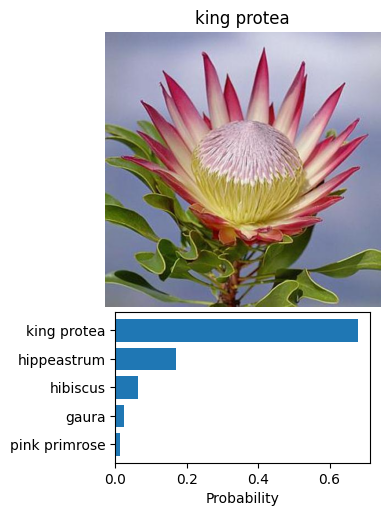

In [35]:
image_path = test_dir + '/13/image_05769.jpg'
probs, classes = predict(image_path, model)
max_index = np.argmax(probs)
max_probability = probs[max_index]
label = classes[max_index]

fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)

image = Image.open(image_path)
ax1.axis('off')
ax1.set_title(cat_to_name[label])
ax1.imshow(image)
labels = []
for cl in classes:
    labels.append(cat_to_name[cl])
y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels)
ax2.invert_yaxis()  # probabilities read top-to-bottom
ax2.set_xlabel('Probability')
ax2.barh(y_pos, probs, xerr=0, align='center')

plt.show()